In [2]:
!pip install seaborn
!pip install plotly


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


# C. Stock Market Prediction ([Dataset link](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset/data))

This dataset contains historical daily prices for all tickers currently trading
on NASDAQ. The up to date list is available from nasdaqtrader.com. 

The historic data is retrieved from Yahoo finance via yfinance python package.
You will train machine learning models for stock price prediction based on
this dataset. Inputs and outputs of ML models are given below. Input and
output of ML models are given below.
<br><br>
**Input:** Historical stock price.  <br><br>
**Output:** Future stock price.

In [4]:
import pandas as pd
import numpy as np

# plotting
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px # for interactive plot 

In [5]:
apple = pd.read_csv("stock/AAPL.csv")
apple['Date'] = pd.to_datetime(apple['Date']) # converting Date col to datetime format 
apple.sort_values('Date', inplace=True) # sort by date
apple.reset_index(drop=True, inplace=True) # drops old index and thus reseting the index since after reordering they will be out of order 
apple.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
5,1980-12-19,0.504464,0.506696,0.504464,0.504464,0.399707,12157600
6,1980-12-22,0.529018,0.531250,0.529018,0.529018,0.419162,9340800
7,1980-12-23,0.551339,0.553571,0.551339,0.551339,0.436848,11737600
8,1980-12-24,0.580357,0.582589,0.580357,0.580357,0.459840,12000800
9,1980-12-26,0.633929,0.636161,0.633929,0.633929,0.502287,13893600


In [6]:
apple.size

69363

# EDA 

`Date`: The date the trading happened (in this case, starting Dec 12, 1980) <br>
`Open`: The **price at which the stock opened** at the beginning of the trading day.<br> 
`High`: The **highest price** the stock reached during that trading day <br>
`Low`: The **lowest price** it dropped to during the day <br>
`Close`: The **price at which the stock closed** at the end of the trading day. <br>
`Adj Close`: The **adjusted closing price** after accounting for stock splits, dividends, etc. Its often used in backtesting because it reflects the stocks "true" value. <br>
`Volume`: The **number of the shares traded** during that data. High volume can indicate high interest or activity on that stock. <br>

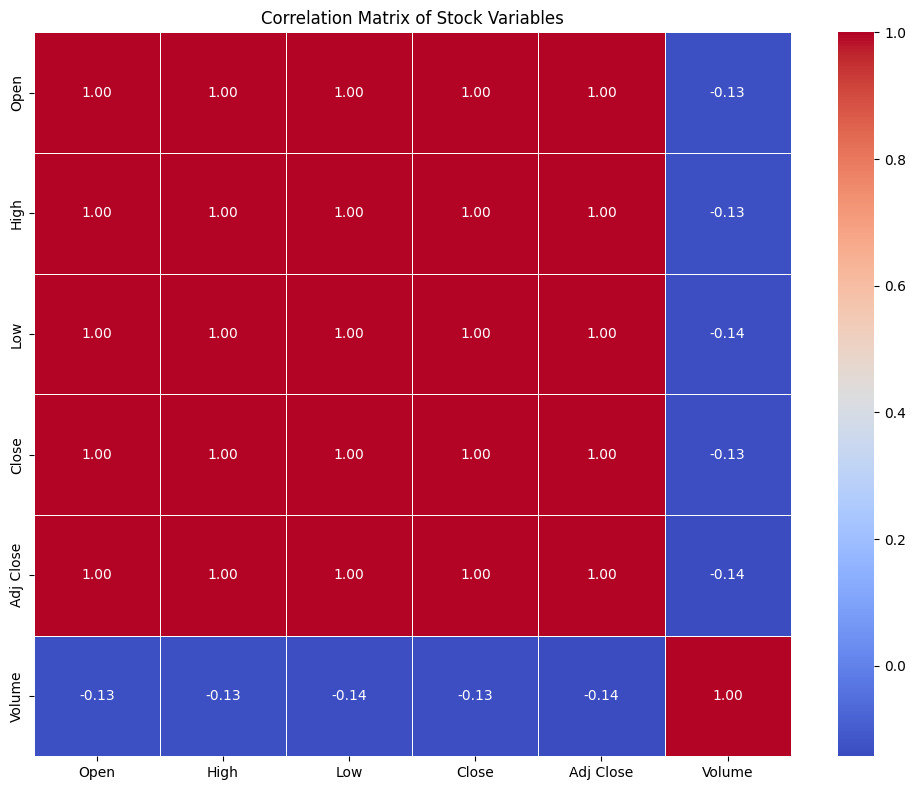

In [9]:
plt.figure(figsize=(10, 8))
corr = apple[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()
sb.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Stock Variables')
plt.tight_layout()
plt.show()

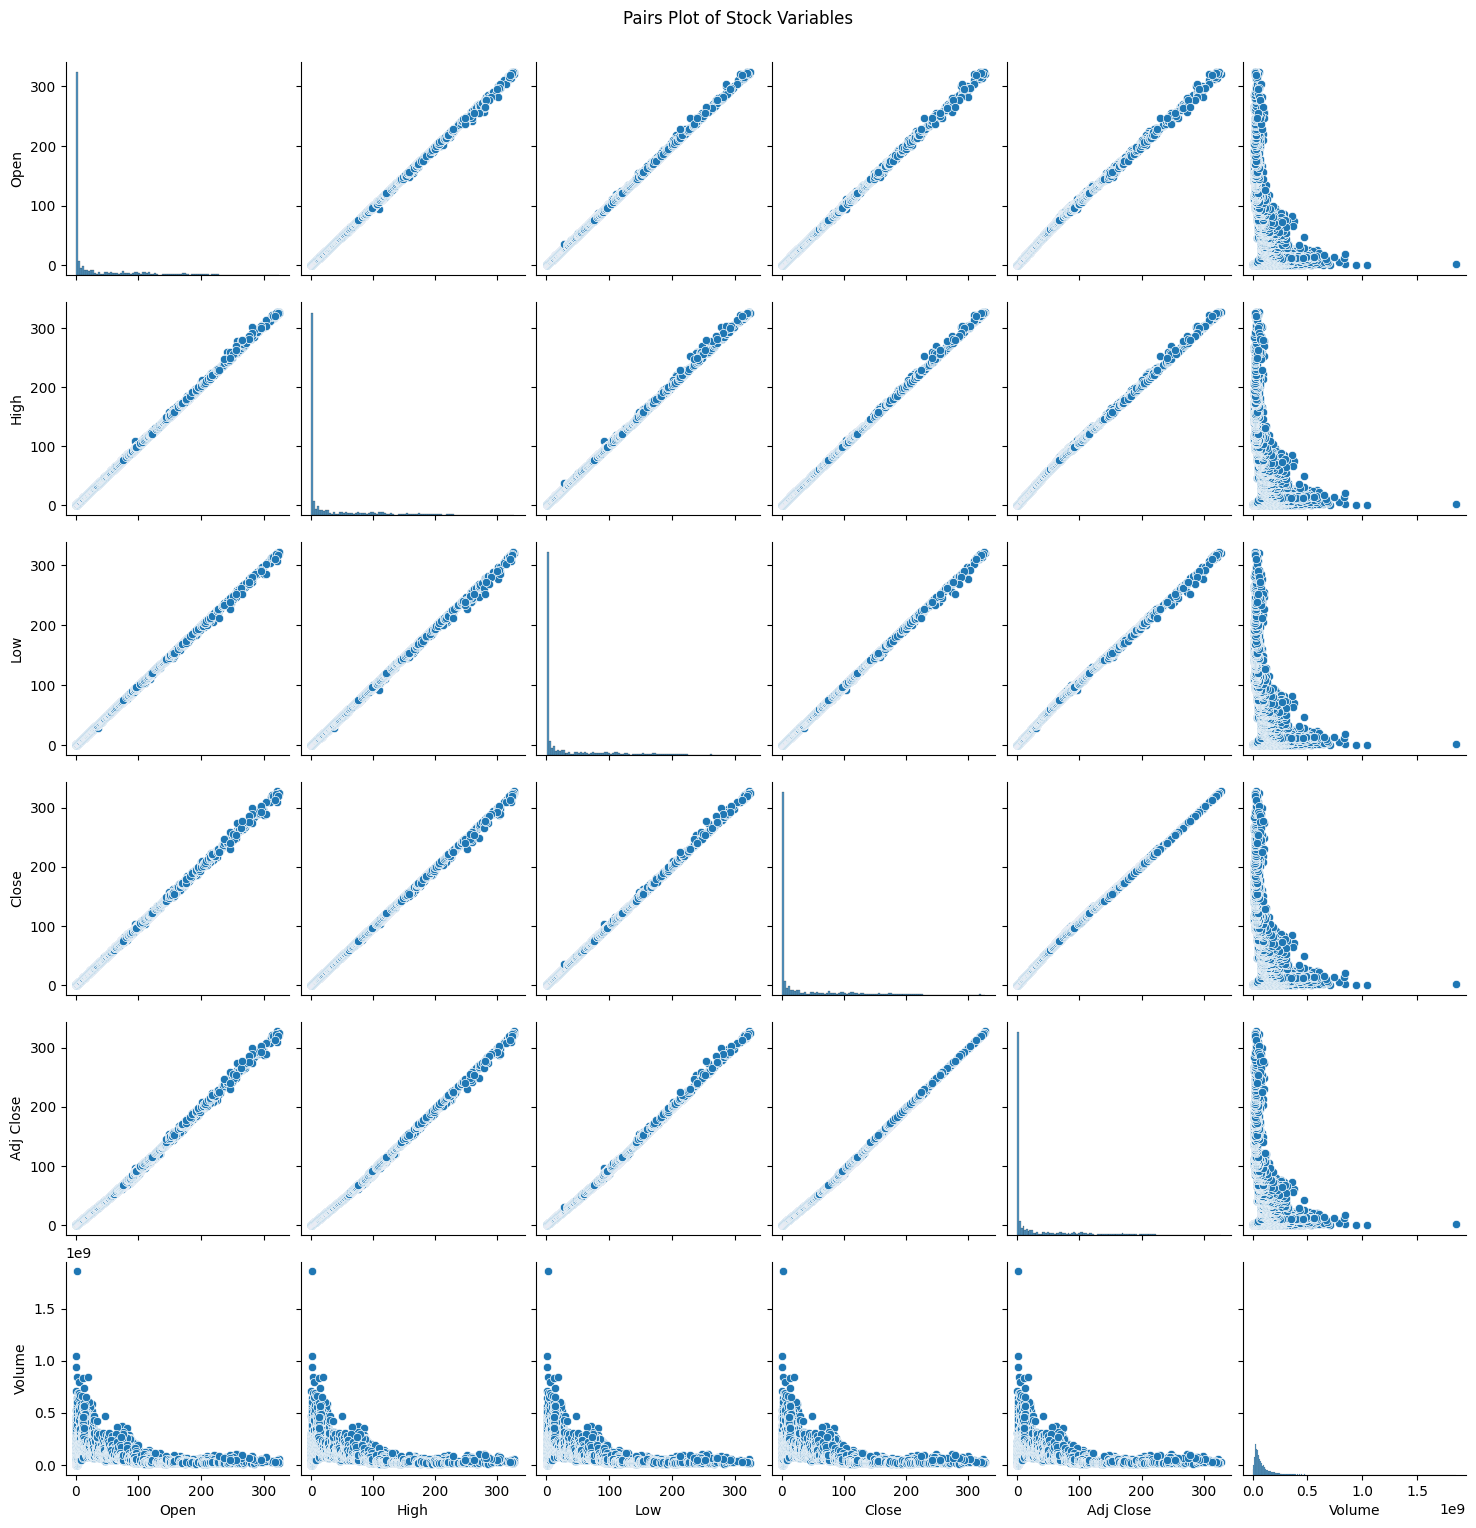

In [10]:
# Select variables of interest
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Create the pairs plot
sb.pairplot(apple[features])
plt.suptitle('Pairs Plot of Stock Variables', y=1.02)
plt.show()


Notes: <br> 
`Adj Close` helps normalize stock data across splits and dividends and **is normalized verstion that reflects the stocks true value over time adjusting for corporate actions like stock splits or dividend payouts** (if not normalize  it can distort historical comparisons)

* **Stocks splits** (which reduce the price but increase the share count)
* **Dividends** (which reduce the value of the stock on payout)

## Overview of Stock Prices (Line plots of Close, Adj Close)

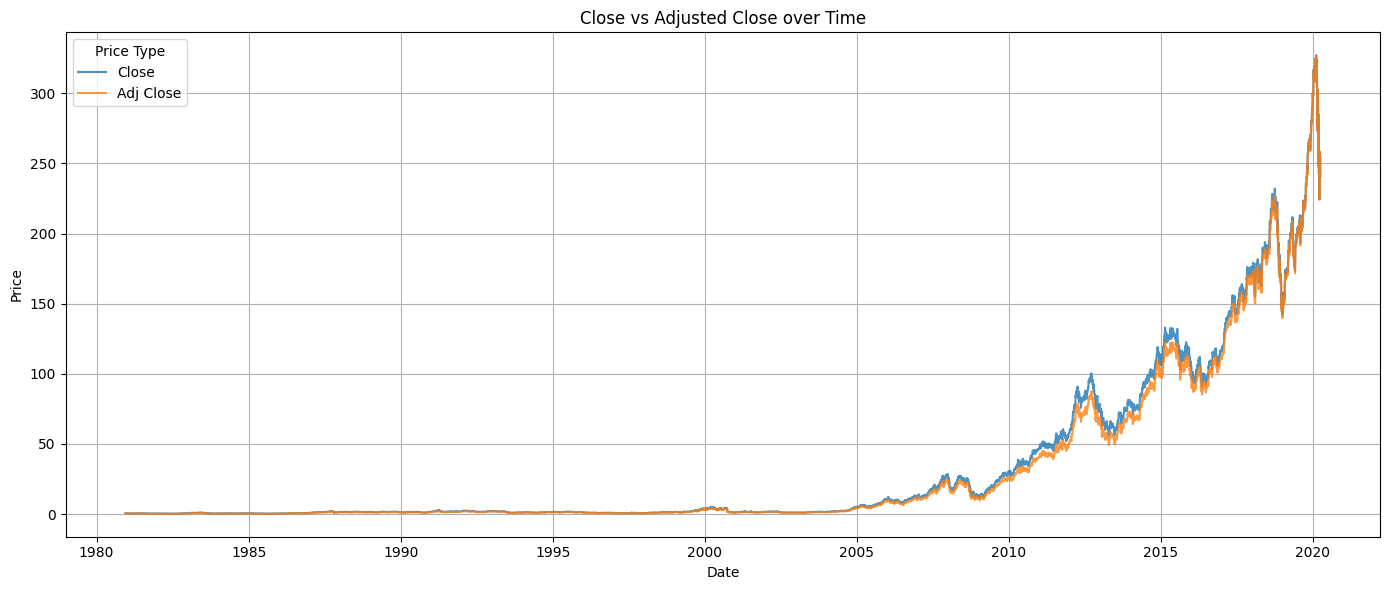

In [13]:
# side by side comparison between Close and Adj Close

apple_melted = apple.melt(id_vars='Date', # first, melt the dataframe to long format
                        value_vars=['Close', 'Adj Close'],
                        var_name='Price Type',  # stores value vars 
                        value_name='Price') # y axis 
# plot
plt.figure(figsize=(14, 6))
sb.lineplot(data=apple_melted, x='Date', y='Price', hue='Price Type', alpha=0.8)

plt.title('Close vs Adjusted Close over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Price Type')
plt.grid(True)

plt.tight_layout()
plt.show()


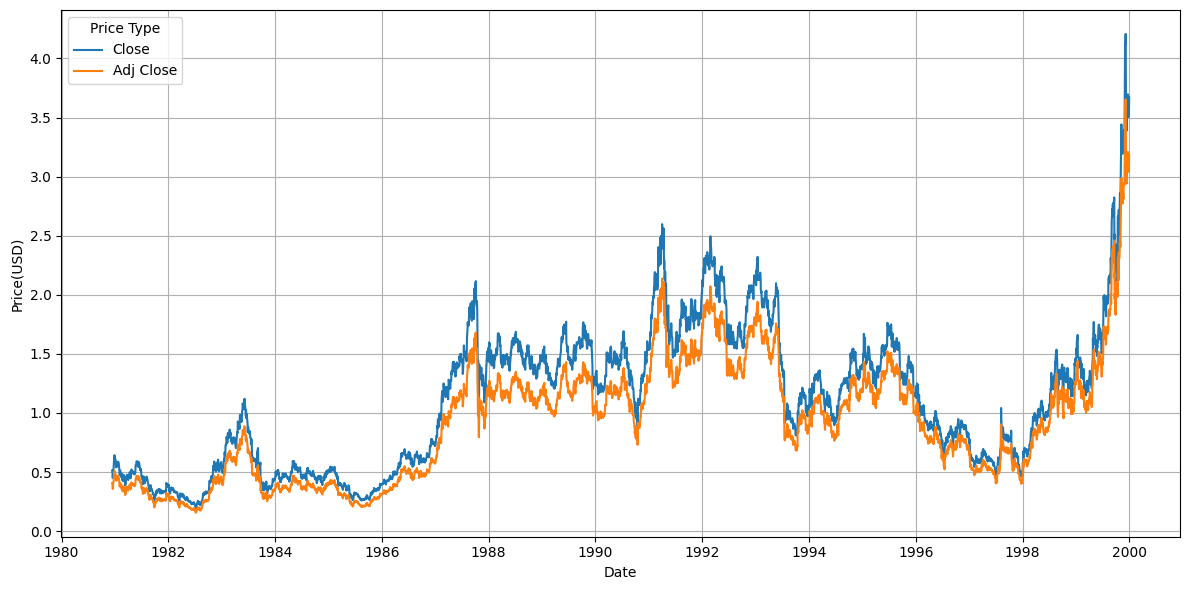

In [14]:
# prepare data (same as before)
apple_filtered = apple[apple['Date'] < '2000-01-01'].copy()

apple_filtered['Date'] = pd.to_datetime(apple_filtered['Date'])

# melt for long format
apple_long = apple_filtered.melt(id_vars='Date', 
                            value_vars=['Close', 'Adj Close'],
                            var_name='Price Type',
                            value_name='Price')

plt.figure(figsize=(12, 6))
sb.lineplot(data = apple_long, x = 'Date', y = 'Price', hue = 'Price Type')

plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

It looks like somewhere before the 2000s the stocks were much cheaper then. Perhaps logarithmic scaling might be more appropriate to show early variations. 

In [16]:
# interactive plot for closer inspection of the data in the time frame displayed above
fig = px.line(apple_long, x='Date', y='Price', color='Price Type',
            title='Apple Stock: Close vs Adjusted Close (Before 2000)',
            labels={'Date': 'Date', 'Price': 'Price (USD)'})

fig.update_layout(legend_title_text='Price Type')
fig.write_html("apple_stock_plot.html") # you can open this interactive plot that is generated for close inspection using your browser (:

In [17]:
# checking the average value of all columns
apple.mean(numeric_only=True)

Open         3.260685e+01
High         3.293608e+01
Low          3.227756e+01
Close        3.261803e+01
Adj Close    3.057657e+01
Volume       8.582916e+07
dtype: float64

## Behavior of Daily Returns (Histograms + Summary Stats)

Return value: how much the stock's price changed from one day to the next <br>
Daily Return = (Today's close - yesterday's close) / yesterdays's close <br>
then mult by 100 to get its percentage

Daily returns help interpret the following:
- measures volatility (how risky the stock is)
- see trends (upward or downward)
- calculate investement performance
- compare stocks over time

Overall
Daily return represents % change in stock price from the previous day. It tells you how much money you gained or lost if you held that stock for one day. 

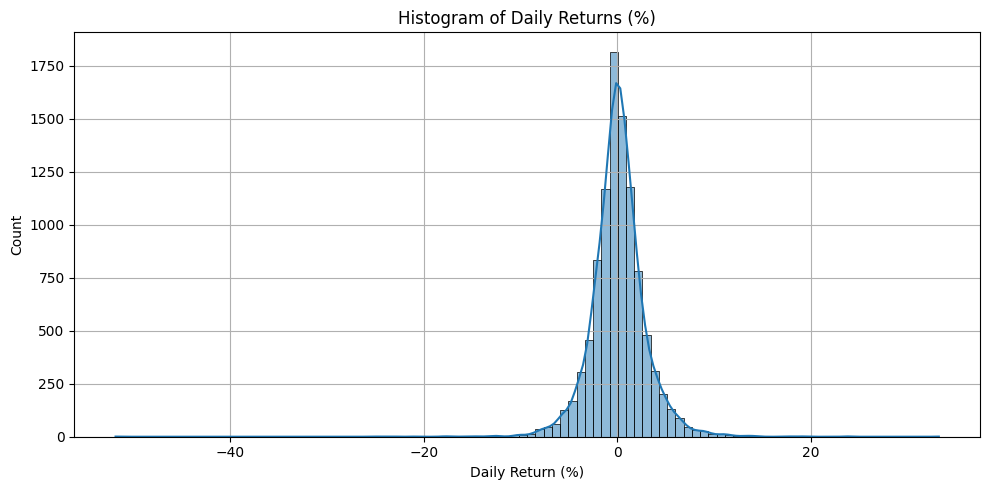

count    9908.000000
mean        0.104133
std         2.873774
min       -51.869158
25%        -1.331956
50%         0.000000
75%         1.474450
max        33.227849
Name: Daily Return %, dtype: float64


In [19]:
# Calculate daily returns
apple['Daily Return %'] = apple['Close'].pct_change() * 100

# Histogram of returns
plt.figure(figsize=(10, 5))
sb.histplot(apple['Daily Return %'], kde=True, bins=100)
plt.title('Histogram of Daily Returns (%)')
plt.xlabel('Daily Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Summary statistics
print(apple['Daily Return %'].describe())

### Interpretations: 
- On most trading days, Apples stocks moves only a little bit up or down (most of the time dont make wild swings)
- The histogram is very narrow and tall, which could indicate large number of days with very small gains/losses (low volatility) 

** notes:
new termenologies i learned

- high kurtosis, which is represented by the sharp peak that suggests the distribution has high kurtosis (i.e. many small changes and rare big ones)


- Heavy tails which indicate there are very few days with extremely large gains or losses

In [21]:
# Top 10 biggest daily gains
top_gains = apple.nlargest(10, 'Daily Return %')[['Date', 'Daily Return %']]
print("Top 10 Daily Gains:")
print(top_gains)

# Top 10 biggest daily losses
top_losses = apple.nsmallest(10, 'Daily Return %')[['Date', 'Daily Return %']]
print("\n Top 10 Daily Losses:")
print(top_losses)

Top 10 Daily Gains:
           Date  Daily Return %
4208 1997-08-06       33.227849
4311 1998-01-02       23.809522
3942 1996-07-18       23.703701
4313 1998-01-06       19.291339
3246 1993-10-15       18.947367
1738 1987-10-29       17.910450
1732 1987-10-21       17.391306
4190 1997-07-11       14.622642
4760 1999-10-14       14.299659
4505 1998-10-09       13.995938

 Top 10 Daily Losses:
           Date  Daily Return %
5003 2000-09-29      -51.869158
702  1983-09-23      -25.384616
1730 1987-10-19      -24.352329
3182 1993-07-16      -23.076923
1735 1987-10-26      -21.126764
7012 2008-09-29      -17.919525
4060 1997-01-06      -17.816093
5203 2001-07-18      -17.171315
5050 2000-12-06      -15.808822
5431 2002-06-19      -15.037225


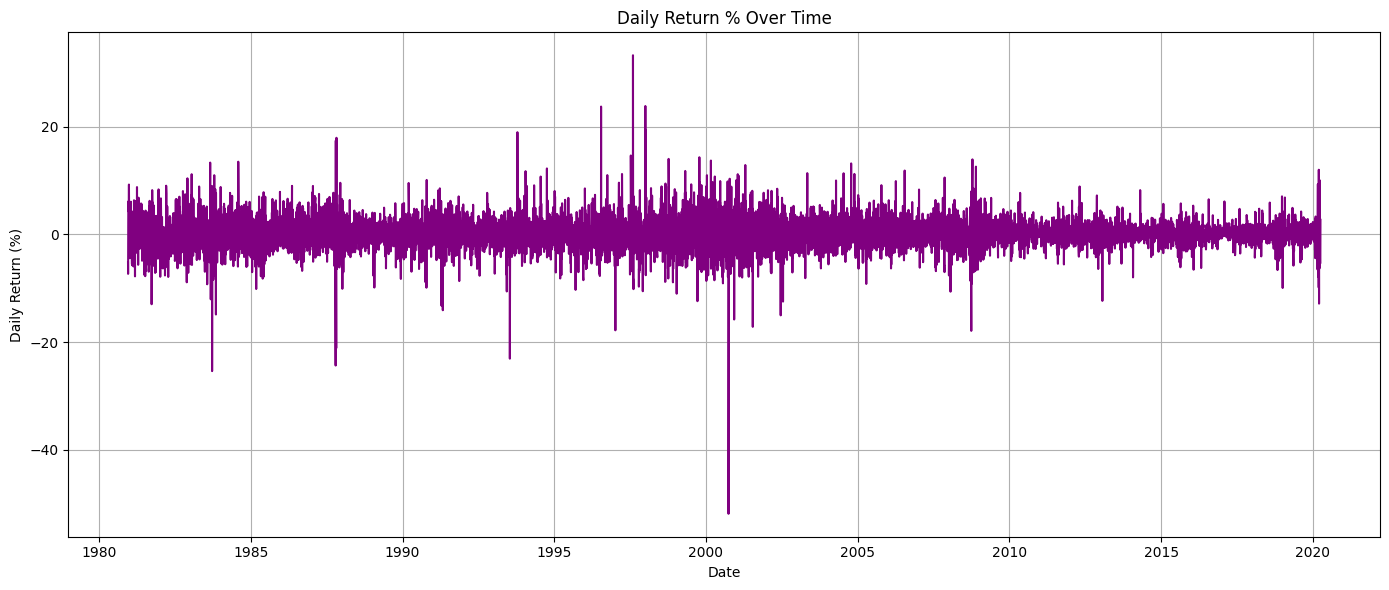

In [22]:
plt.figure(figsize=(14, 6))
sb.lineplot(x='Date', y='Daily Return %', data=apple, color='purple')
plt.title('Daily Return % Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

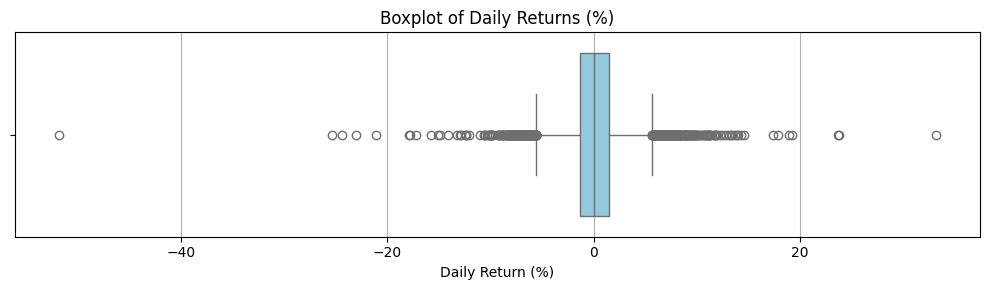

In [23]:
plt.figure(figsize=(10, 3))
sb.boxplot(x=apple['Daily Return %'], color='skyblue')
plt.title('Boxplot of Daily Returns (%)')
plt.xlabel('Daily Return (%)')
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [24]:
apple['Daily Return %'].skew()
apple['Daily Return %'].kurtosis()

np.float64(18.00895894716333)

# Data Processing

In [26]:
#importing the required libraries

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch

### 1. Preparing Data for Pytorch

In [28]:
# ========== preparing features and target ==========

# features
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
X = apple[features].values

# target: next day's Close price
y = apple['Close'].shift(-1).dropna().values
X = X[:-1]  # Drop last X to align with y

# normalize features
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# normalize target y separately
scaler_y = MinMaxScaler()
y = y.reshape(-1, 1)         # y must be 2D for MinMaxScaler
y = scaler_y.fit_transform(y)


### 2. Data Preparation: Sliding Window and Tensor Conversion

To model stock price prediction as a supervised learning task, the original time-series data must first be restructured into fixed-length input-output sequences. A Sliding Window approach is applied, where each input sequence consists of 30 consecutive days of features (Open, High, Low, Close, Adjusted Close, Volume), and the corresponding output is the closing price of the next day.

Following sequence creation, the dataset is divided into training and testing sets using an 80/20 split, ensuring that the chronological order of the stock data is preserved by avoiding any shuffling. This temporal integrity is crucial for time-series forecasting tasks.

Finally, the training and testing sets are converted into PyTorch tensors to facilitate model training. Features (X) are stored as 3-dimensional tensors (batch size, sequence length, number of features), and targets (y) are reshaped appropriately to match the output expectations of the network.


In [30]:
# ========== sliding windows ==========

SEQUENCE_LENGTH = 30  # we want to predict the next day's price based on the last 30 days

def create_sequences(X, y, seq_length):
    X_seq = []
    y_seq = []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, y, SEQUENCE_LENGTH)

dates = apple['Date'].values[SEQUENCE_LENGTH:]

# train/test split (no shuffle!) 
split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

dates_train, dates_test = dates[:split_idx], dates[split_idx:]

# convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32) 
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # reshape to 2D
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print(f"X_train shape: {X_train.shape}") 
print(f"y_train shape: {y_train.shape}")

X_train shape: torch.Size([7902, 30, 6])
y_train shape: torch.Size([7902, 1])


# LSTM
Outline
1. LSTM model architecture (input size, hidden size, number of layers)
2. Loss function and optimizer
3. Early stopping and best model checkpointing
- Motivation: underfitting observed early ➔ train longer, efficiently
- Restore best model after training

In [32]:
#importing the required libraries

# modeling libraries
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.metrics import mean_squared_error
import time

### 3. Defining LSTM model

In [34]:

# ==========================================
# set random seed for reproducibility
# ==========================================
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0) 

# ==========================================
# defining StockLSTM model
# ==========================================
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take output from last timestep
        out = self.fc(out)
        return out


### 4. Model Setup and Training Strategy 

The prediction model used in this project is a Long Short-Term Memory (LSTM) network. The input size is set to match the number of features (six stock attributes: Open, High, Low, Close, Adjusted Close, Volume), and the hidden size is set to 128 units with one LSTM layer. The model is trained using the Adam optimizer with a learning rate of 0.001, and the loss function is Mean Squared Error (MSE), appropriate for continuous-value regression tasks.

To ensure efficient training and avoid unnecessary overfitting or prolonged computation, an Early Stopping mechanism is implemented. During training, the model’s loss is continuously monitored, and the best-performing model checkpoint is saved. Training halts automatically if no improvement in loss is observed after 10 consecutive epochs. This decision was motivated by early observations of underfitting behavior, where models trained for insufficient durations produced overly flat predictions compared to actual stock price movements. Early Stopping allows the model additional opportunities to learn without risking overtraining, while maintaining computational efficiency by terminating training once further progress becomes negligible.

After Early Stopping is triggered, the best model weights (lowest validation loss) are restored for evaluation.


In [36]:
# ==========================================
# model setup
# ==========================================
input_size = X_train.shape[2]  # 6 features
hidden_size = 128
num_layers = 1

model = StockLSTM(input_size, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# training Setup (early stopping + checkpoint)
# ==========================================
patience = 10
best_loss = float('inf')
trigger_times = 0
best_model_path = 'best_lstm_model.pth'

num_epochs = 100
train_losses = []

# ==========================================
# training Loop
# ==========================================
lstm_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    
    output = model(X_train)
    loss = criterion(output, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_loss = loss.item()
    train_losses.append(current_loss)
    
    # save best model checkpoint
    if current_loss < best_loss:
        best_loss = current_loss
        trigger_times = 0
        torch.save(model.state_dict(), best_model_path)  # saving best model
    else:
        trigger_times += 1
    
    # printing progress
    if (epoch + 1) % 10 == 0 or trigger_times >= patience:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {current_loss:.6f}')
    
    # early stopping condition
    if trigger_times >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break
lstm_end_time = time.time()
# ==========================================
# load best model after early stopping
# ==========================================
model.load_state_dict(torch.load(best_model_path))
model.eval()
lstm_training_time = lstm_end_time - lstm_start_time
print(f"\nTraining model took {lstm_training_time:.4f} seconds.")

Epoch 10/100, Loss: 0.001162
Epoch 20/100, Loss: 0.000568
Epoch 30/100, Loss: 0.000031
Epoch 39/100, Loss: 0.000044
Early stopping triggered at epoch 39!

Training model took 65.7235 seconds.


### 5. Plotting the loss curve 

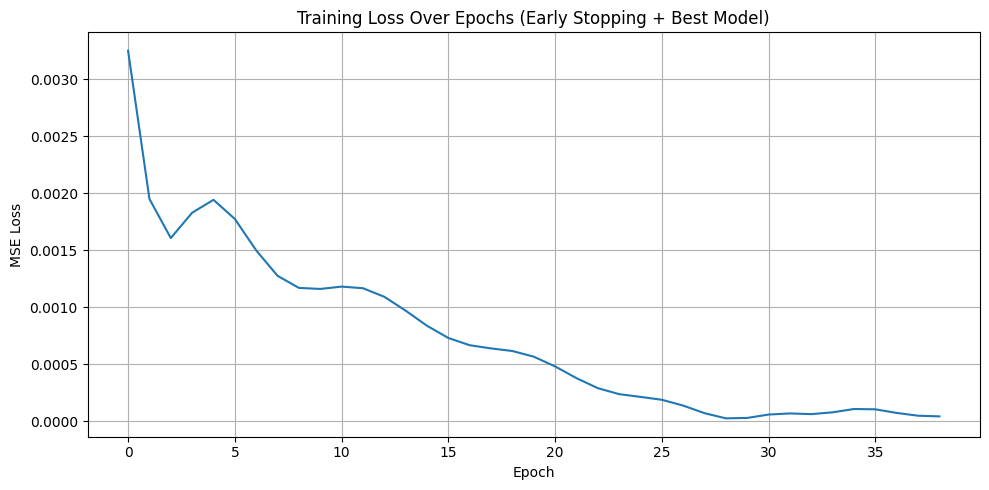

In [38]:

# ==========================================
#  plot training loss curve
# ==========================================
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.title('Training Loss Over Epochs (Early Stopping + Best Model)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()

plt.savefig('lstm_training_loss.png')

plt.show()

### 6. Model Evaluation: Actual vs Predicted Close Prices (Post-Inverse Scaling)

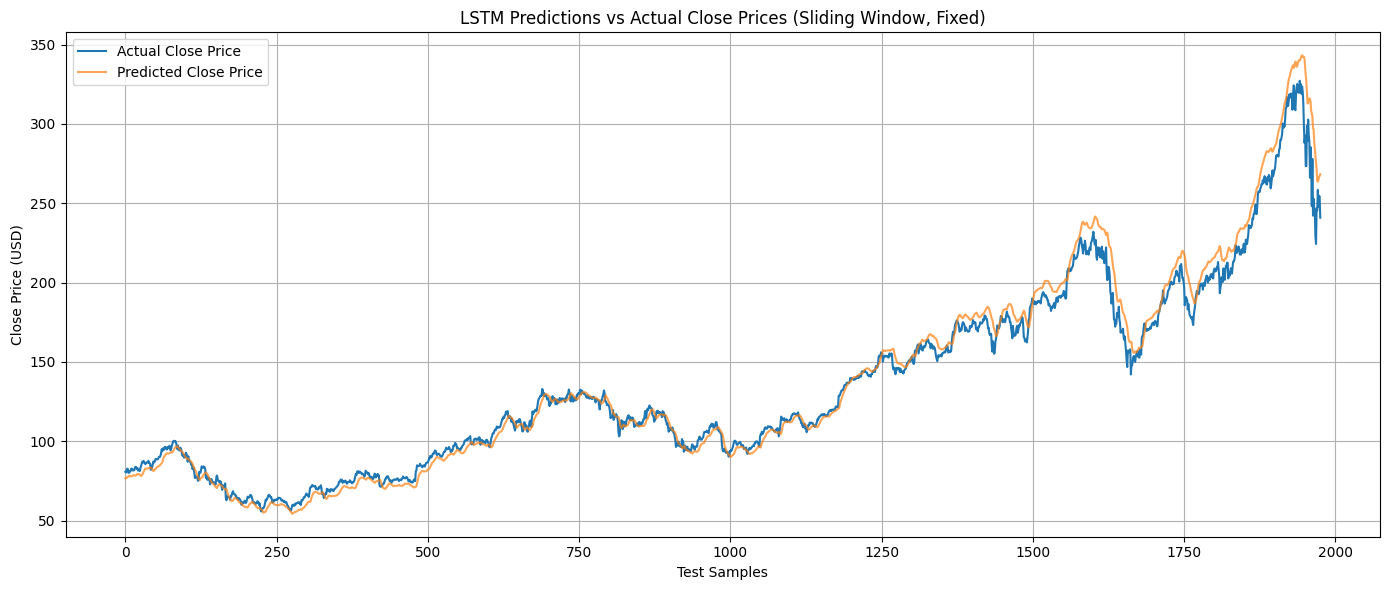

In [40]:
# predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# convert to numpy
y_pred = y_pred.numpy()
y_test_np = y_test.numpy()

# inverse transform to real prices
y_pred_real = scaler_y.inverse_transform(y_pred)
y_test_real = scaler_y.inverse_transform(y_test_np)

# plot Actual vs Predicted (in true USD scale)
plt.figure(figsize=(14,6))
plt.plot(y_test_real, label='Actual Close Price')
plt.plot(y_pred_real, label='Predicted Close Price', alpha=0.7)
plt.title('LSTM Predictions vs Actual Close Prices (Sliding Window, Fixed)')
plt.xlabel('Test Samples')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('lstm_predictions_vs_actual.png')

plt.show()

In [41]:
from sklearn.metrics import mean_squared_error

# evaluate MSE and RMSE
lstm_mse = mean_squared_error(y_test_real, y_pred_real)
lstm_rmse = np.sqrt(lstm_mse)

print(f"Test MSE: {lstm_mse:.4f}")
print(f"Test RMSE: {lstm_rmse:.4f}")


Test MSE: 71.2377
Test RMSE: 8.4402


# RNN
Outline
1. RNN model architecture (input size, hidden size, number of layers)
2. Loss function and optimizer
3. Early stopping and best model checkpointing
- Motivation: compare performance of RNN, which is suceptable to vanishing gradient issues, with the LSTM
- Restore best model after training

In [43]:
#importing the required libraries

# modeling libraries
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.metrics import mean_squared_error
import time

### 3. Defining RNN model

In [45]:
# ==========================================
# set random seed for reproducibility
# ==========================================
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(0)

# ==========================================
# defining RNN model
# ==========================================
class RNNModel(nn.Module):
    def __init__(self, num_input, num_hidden_nodes, num_hidden_layers, num_output):
        super(RNNModel, self).__init__()
        
        self.num_hidden_nodes = num_hidden_nodes
        self.num_hidden_layers = num_hidden_layers
        
        self.rnn = nn.RNN(num_input, num_hidden_nodes, num_hidden_layers, batch_first=True, nonlinearity='relu')
    
        self.fc = nn.Linear(num_hidden_nodes, num_output)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # take output from last timestep
        out = self.fc(out)
        return out


### 4. Model Setup and Training Strategy 

The prediction model used in this section is a Reccurent Neural Network. The input size is set to match the number of features (six stock attributes: Open, High, Low, Close, Adjusted Close, Volume), and the hidden size is set to 128 units with one layer. The model is trained using the Adam optimizer with a learning rate of 0.001, and the loss function is Mean Squared Error (MSE).
Like with the LSTM model, to ensure efficient training and an adequate setting for comparision between models, an Early Stopping mechanism is implemented with training halting automatically if no improvement in loss is observed after 10 consecutive epochs.

After Early Stopping is triggered, the best model weights (lowest validation loss) are restored for evaluation.

In [47]:
# ==========================================
# model setup
# ==========================================
num_input = X_train.shape[2]  # 6 features
num_hidden_nodes = 128
num_hidden_layers = 1
num_output = 1 #regression task so one output (continuous variable)

model = RNNModel(num_input, num_hidden_nodes, num_hidden_layers, num_output)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# training Setup (early stopping + checkpoint)
# ==========================================
patience = 10
best_loss = float('inf')
trigger_times = 0
best_model_path = 'best_rnn_model.pth'

num_epochs = 100
train_losses = []

# ==========================================
# training Loop
# ==========================================
rnn_start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    
    output = model(X_train)
    loss = criterion(output, y_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    current_loss = loss.item()
    train_losses.append(current_loss)
    
    # save best model checkpoint
    if current_loss < best_loss:
        best_loss = current_loss
        trigger_times = 0
        torch.save(model.state_dict(), best_model_path)  # saving best model
    else:
        trigger_times += 1
    
    # printing progress
    if (epoch + 1) % 10 == 0 or trigger_times >= patience:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {current_loss:.6f}')
    
    # early stopping condition
    if trigger_times >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}!")
        break
rnn_end_time = time.time()
# ==========================================
# load best model after early stopping
# ==========================================
model.load_state_dict(torch.load(best_model_path))
model.eval()
rnn_training_time = rnn_end_time - rnn_start_time
print(f"\nTraining model took {rnn_training_time:.4f} seconds.")

Epoch 10/100, Loss: 0.002735
Epoch 20/100, Loss: 0.001212
Epoch 30/100, Loss: 0.000677
Epoch 40/100, Loss: 0.000245
Epoch 50/100, Loss: 0.000008
Epoch 60/100, Loss: 0.000017
Early stopping triggered at epoch 60!

Training model took 16.5559 seconds.


### 5. Plotting the loss curve 

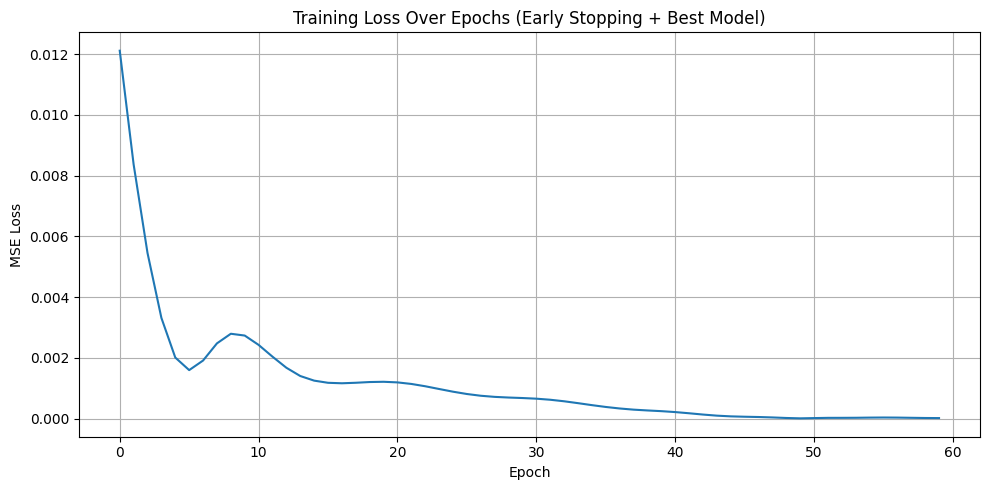

In [49]:
# ==========================================
#  plot training loss curve
# ==========================================
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.title('Training Loss Over Epochs (Early Stopping + Best Model)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.tight_layout()

plt.savefig('rnn_training_loss.png')

plt.show()

### 6. Model Evaluation: Actual vs Predicted Close Prices (Post-Inverse Scaling)

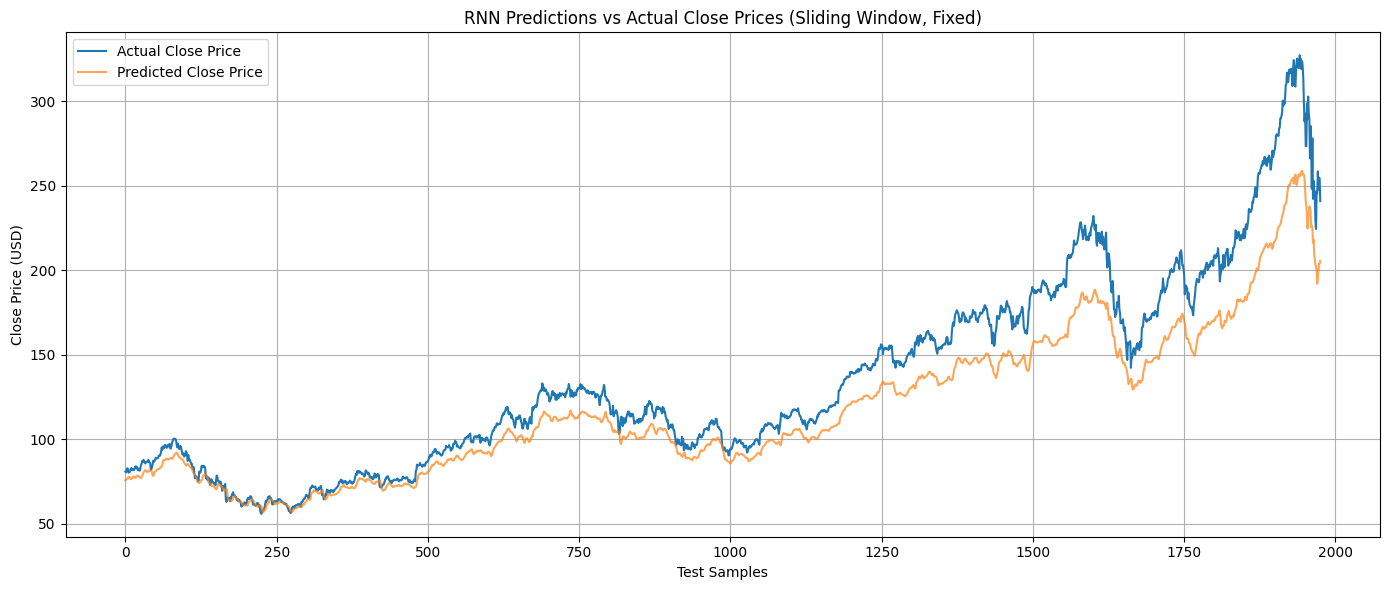

In [51]:
# predict
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# convert to numpy
y_pred = y_pred.numpy()
y_test_np = y_test.numpy()

# inverse transform to real prices
y_pred_real = scaler_y.inverse_transform(y_pred)
y_test_real = scaler_y.inverse_transform(y_test_np)

# plot Actual vs Predicted (in true USD scale)
plt.figure(figsize=(14,6))
plt.plot(y_test_real, label='Actual Close Price')
plt.plot(y_pred_real, label='Predicted Close Price', alpha=0.7)
plt.title('RNN Predictions vs Actual Close Prices (Sliding Window, Fixed)')
plt.xlabel('Test Samples')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('rnn_predictions_vs_actual.png')

plt.show()

In [52]:
# evaluate MSE and RMSE
rnn_mse = mean_squared_error(y_test_real, y_pred_real)
rnn_rmse = np.sqrt(rnn_mse)

print(f"Test MSE: {rnn_mse:.4f}")
print(f"Test RMSE: {rnn_rmse:.4f}")

Test MSE: 509.1830
Test RMSE: 22.5651


# Comparision

In [54]:
import matplotlib.image as mpimg
import pandas as pd

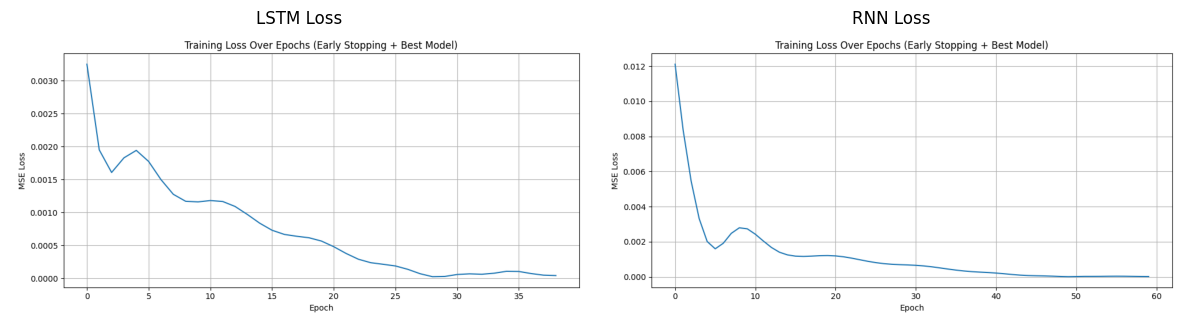

In [55]:
#Loss Graphs

# Load images
img1 = mpimg.imread('lstm_training_loss.png')
img2 = mpimg.imread('rnn_training_loss.png')

# Create figure and axes so images combine
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))  # 1 row, 2 columns

# Images settings
ax1.imshow(img1)
ax1.set_title('LSTM Loss')
ax1.axis('off')

ax2.imshow(img2)
ax2.set_title('RNN Loss')
ax2.axis('off')


plt.tight_layout()
plt.show()

### Loss interpretation
LSTM stopped sooner at 39 epochs with a loss = 0.000044 than RNN which stopped at 60 with a loss = 0.000017
meaning LSTM was able to find a stable minima faster than RNN but RNN had a lower training loss.


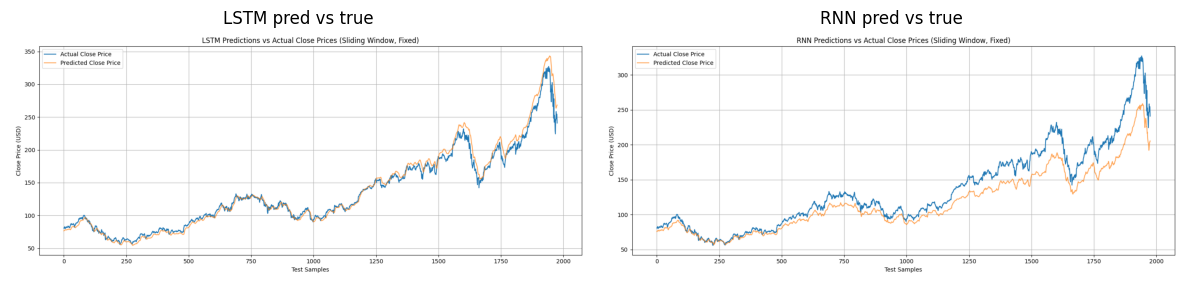

In [57]:
# Predictions vs actuals

# Load images
img1 = mpimg.imread('lstm_predictions_vs_actual.png')
img2 = mpimg.imread('rnn_predictions_vs_actual.png')

# Create figure and axes so images combine
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))  # 1 row, 2 columns

# Images settings
ax1.imshow(img1)
ax1.set_title('LSTM pred vs true')
ax1.axis('off')

ax2.imshow(img2)
ax2.set_title('RNN pred vs true')
ax2.axis('off')


plt.tight_layout()
plt.show()

In [58]:
#LSTM
date_model_stops_under_predicting = pd.to_datetime(dates_test[600]).strftime('%B %d, %Y')
date_model_starts_over_predicting = pd.to_datetime(dates_test[1300]).strftime('%B %d, %Y')

print(f"LSTM - Even predictions start {date_model_stops_under_predicting}")
print(f"LSTM - Over predictions start {date_model_starts_over_predicting}")

# RNN
date_model_under = pd.to_datetime(dates_test[500]).strftime('%B %d, %Y')
date_model_very_under = pd.to_datetime(dates_test[1150]).strftime('%B %d, %Y')
print()
print(f"RNN - Small under predictions start {date_model_under}")
print(f"RNN - Severe under predictions start {date_model_stops_under_predicting}")

# Other
date_steeper_inc_start = pd.to_datetime(dates_test[1000]).strftime('%B %d, %Y')
date_large_crash = pd.to_datetime(dates_test[1600]).strftime('%B %d, %Y')
date_large_crash_end = pd.to_datetime(dates_test[1675]).strftime('%B %d, %Y')
date_peak = pd.to_datetime(dates_test[1940]).strftime('%B %d, %Y')

print()
print(f"Increase where LSTM continues to predict well but RNN really struggles is {date_steeper_inc_start}")
print(f"Crash from {date_large_crash} to {date_large_crash_end}")
print(f"Peak price on {date_peak}")

LSTM - Even predictions start October 13, 2014
LSTM - Over predictions start July 25, 2017

RNN - Small under predictions start May 21, 2014
RNN - Severe under predictions start October 13, 2014

Increase where LSTM continues to predict well but RNN really struggles is May 16, 2016
Crash from October 02, 2018 to January 22, 2019
Peak price on February 10, 2020


### Predictions interpretation
The LSTM model tended to minorly underpredict closing price until about October 13, 2014 where it very closly matched closing price but started to overpredict about 3 years later. In contrast, RNN began predicting very close to the actual closing price but started to predict lower closing prices than the actual. The gap between the actual and predicted value continued to widen with the RNN consistently underpredicting and started to severly underpredict closing price starting around October 13, 2014 when the market seemed to be in a longer period of increase and had a steeper than prior increase.

In [85]:
# MSEs
mses = pd.DataFrame({
    'LSTM MSE': [lstm_mse],
    'RNN MSE': [rnn_mse],
})

rmses = pd.DataFrame({
    'LSTM RMSE': [lstm_rmse],
    'RNN RMSE': [rnn_rmse],
})

print(mses.to_string(index=False))
print()
print(rmses.to_string(index=False))

 LSTM MSE    RNN MSE
71.237701 509.182953

 LSTM RMSE  RNN RMSE
  8.440243 22.565083


### MSE interpretation
The LSTM model significantly outperforms the RNN model, according to MSE, where there is a 500% increase in error when using the RNN model. As expected the LSTM performed better than the RNN because it doesn't have the vanishing gradient issue that the RNN does with our long sequence data.

In [104]:
times = pd.DataFrame({
    'LSTM time (sec)': [lstm_training_time],
    'RNN time (sec)': [rnn_training_time],
})

print(times.to_string(index=False))

 LSTM time (sec)  RNN time (sec)
        65.72349       16.555855


### Time interpretation
The LSTM took 4 times longer to train, which makes sense because it has a more complex architecture and more weights to update. That being said, a minute isn't an unreasonably long length of time to wait for the model to train and the tradoff of a vastly superior error rate using the LSTM is worth the longer wait.